In [2]:
import pickle
import sys
sys.path.append("../../spike")
import spike.multirecording_spikeanalysis as spike
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import sem
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
import matplotlib.patches as mpatches
from itertools import combinations
from matplotlib.patches import Patch
import matplotlib.ticker as ticker
import seaborn as sns
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['figure.titleweight'] = 'bold'

def hex_2_rgb(hex_color): # Orange color
    rgb_color = tuple(int(hex_color[i:i+2], 16) / 255.0 for i in (1, 3, 5))
    return rgb_color

def pickle_this(thing_to_pickle, file_name):
    """
    Pickles things
    Args (2):   
        thing_to_pickle: anything you want to pickle
        file_name: str, filename that ends with .pkl 
    Returns:
        none
    """
    with open(file_name,'wb') as file:
        pickle.dump(thing_to_pickle, file)

def unpickle_this(pickle_file):
    """
    Unpickles things
    Args (1):   
        file_name: str, pickle filename that already exists and ends with .pkl
    Returns:
        pickled item
    """
    with open(pickle_file, 'rb') as file:
        return(pickle.load(file))
    
import spike.spike_analysis.firing_rate_calculations as fr
import spike.spike_analysis.spike_collection as collection
import spike.spike_analysis.spike_recording as recording

import spike.spike_analysis.pca_trajectories as pca_trajectories
import pickle


In [ ]:

def plot_pca_results_3d(pca_result, title, colors, azim, elev, save = False):
    event_lengths = int(
            (pca_result.event_length + pca_result.pre_window + pca_result.post_window) * 1000 / pca_result.timebin
        )
    
    event_end = int((pca_result.event_length + pca_result.pre_window) * 1000 / pca_result.timebin)
    pre_window = pca_result.pre_window * 1000 / pca_result.timebin
    post_window = pca_result.post_window * 1000 / pca_result.timebin
    pc_var = pca_result.explained_variance
    PCA_key = pca_result.labels
    PCA_matrix = pca_result.transformed_data
    col_counter = 0
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(111, projection="3d")
    #plt.subplots_adjust(left=0.3, right=0.99, bottom=0.1, top=0.9)
    for i in range(0, len(PCA_key), event_lengths):
        event_label = PCA_key[i]
        onset = int(i + pca_result.pre_window - 1)
        end = int(i + event_end - 1)
        post = int(i + event_lengths - 1)
        ax.plot3D(
            PCA_matrix[i : i + event_lengths, 0],
            PCA_matrix[i : i + event_lengths, 1],
            PCA_matrix[i : i + event_lengths, 2],
            label=event_label,
            color=colors[col_counter],
            linewidth = 5,
            alpha = 0.8
        )
        ax.scatter(
            PCA_matrix[i, 0],
            PCA_matrix[i, 1],
            PCA_matrix[i, 2],
            marker="s",
            s=100,
            c="w",
            edgecolors=colors[col_counter],
        )
        ax.scatter(
            PCA_matrix[onset, 0],
            PCA_matrix[onset, 1],
            PCA_matrix[onset, 2],
            marker="^",
            s=300,
            c="w",
            edgecolors=colors[col_counter],
        )
        ax.scatter(
            PCA_matrix[end, 0],
            PCA_matrix[end, 1],
            PCA_matrix[end, 2],
            marker="o",
            s=200,
            c="w",
            edgecolors=colors[col_counter],
        )
        if post_window != 0:
            ax.scatter(
                PCA_matrix[post, 0],
                PCA_matrix[post, 1],
                PCA_matrix[post, 2],
                marker="D",
                s=200,
                c="w",
                edgecolors=colors[col_counter],
            )
        col_counter += 1
    ax.legend(loc="upper left", bbox_to_anchor=(.9,1), frameon = False, fontsize = 14)
    # ax.set_xlim(-20, 45)
    # ax.set_ylim(-5, 25)
    # ax.set_zlim(-20, 30)
    ax.view_init(azim = azim, elev =elev)
    ax.set_title(f"{title}", fontsize = 24, y = 1)
    ax.set_xlabel(f"PC1 ({pc_var[0]*100:.1f}% variance)", fontsize = 16, labelpad = -10)
    ax.set_ylabel(f"PC2 ({pc_var[1]*100:.1f}% variance)", fontsize = 16, labelpad = -10)
    ax.set_zlabel(f"PC3 ({pc_var[2]*100:.1f}% variance)", fontsize = 16, labelpad = -10)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.yaxis.pane.set_alpha(0.9)
    ax.xaxis.pane.set_alpha(0.9)
    ax.zaxis.pane.set_alpha(0.9)
    plt.tight_layout()
    if save:
        plt.savefig(f'{title}.png', dpi = 600, transparent = True,bbox_inches='tight' )
    plt.show()


def plot_pca_results_2d(pca_result, title, colors, legend_spot, save=False):
    event_lengths = int(
        (pca_result.event_length + pca_result.pre_window + pca_result.post_window) * 1000 / pca_result.timebin
    )
    
    event_end = int((pca_result.event_length + pca_result.pre_window) * 1000 / pca_result.timebin)
    pre_window = pca_result.pre_window * 1000 / pca_result.timebin
    post_window = pca_result.post_window * 1000 / pca_result.timebin
    pc_var = pca_result.explained_variance
    PCA_key = pca_result.labels
    PCA_matrix = pca_result.transformed_data
    col_counter = 0
    
    # Create figure with updated size
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    
    for i in range(0, len(PCA_key), event_lengths):
        event_label = PCA_key[i]
        onset = int(i + pca_result.pre_window - 1)
        end = int(i + event_end - 1)
        post = int(i + event_lengths - 1)
        
        # Plot the continuous line with updated styling
        ax.plot(
            PCA_matrix[i:i + event_lengths, 0],
            PCA_matrix[i:i + event_lengths, 1],
            label=event_label,
            color=colors[col_counter],
            linewidth=5,
            alpha=0.8,
            zorder = 1
        )
        
        # Add markers with updated sizes
        ax.scatter(
            PCA_matrix[i, 0],
            PCA_matrix[i, 1],
            marker="s",
            s=200,
            c="w",
            edgecolors=colors[col_counter],
            zorder = 2
        )
        ax.scatter(
            PCA_matrix[onset, 0],
            PCA_matrix[onset, 1],
            marker="^",
            s=300,
            c="w",
            edgecolors=colors[col_counter],
            zorder = 3
        )
        ax.scatter(
            PCA_matrix[end, 0],
            PCA_matrix[end, 1],
            marker="o",
            s=200,
            c="w",
            edgecolors=colors[col_counter],
            zorder = 4
        )
        if post_window != 0:
            ax.scatter(
                PCA_matrix[post, 0],
                PCA_matrix[post, 1],
                marker="D",
                s=200,
                c="w",
                edgecolors=colors[col_counter],
                zorder =5
            )
        col_counter += 1
    
    # Updated legend formatting
    ax.legend(loc="upper left", bbox_to_anchor=legend_spot, frameon=False, fontsize=14)
    
    # ax.set_xlim(-20, 45)
    # ax.set_ylim(-5, 25)
    
    # Updated title and label formatting
    ax.set_title(f"{title}", fontsize=24, y=1.01)
    ax.set_xlabel(f"PC1 ({pc_var[0]*100:.1f}% variance)", fontsize=16)
    ax.set_ylabel(f"PC2 ({pc_var[1]*100:.1f}% variance)", fontsize=16)
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])
    
    # Add tight layout
    plt.tight_layout()
    
    if save:
        plt.savefig(f'{title}.png', dpi=600, transparent=True, bbox_inches='tight')
    plt.show()

In [3]:
cagemate_collection = unpickle_this('cagemate_collection.pkl')
novel_collection = unpickle_this('novel_collection.pkl')


In [4]:
cagemate_collection.analyze(timebin = 100, ignore_freq=0.5, smoothing_window=500)
novel_collection.analyze(timebin = 100, ignore_freq=0.5, smoothing_window=500)

All set to analyze
All set to analyze


In [ ]:
color_id_dict = {'novel': hex_2_rgb('#15616F'), 
                    'short-term familiar': (1.0, 0.6862745098039216, 0.0),
                    'long-term familiar': hex_2_rgb('#792910')}

In [ ]:
cagemate_collection.collection[0].event_dict.keys()

dict_keys(['baseline', 'exp1', 'exp2', 'exp3', 'exp4', 'exp5'])

C:\Users\megha\AppData\Local\Temp\ipykernel_6932\4153481633.py:83: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


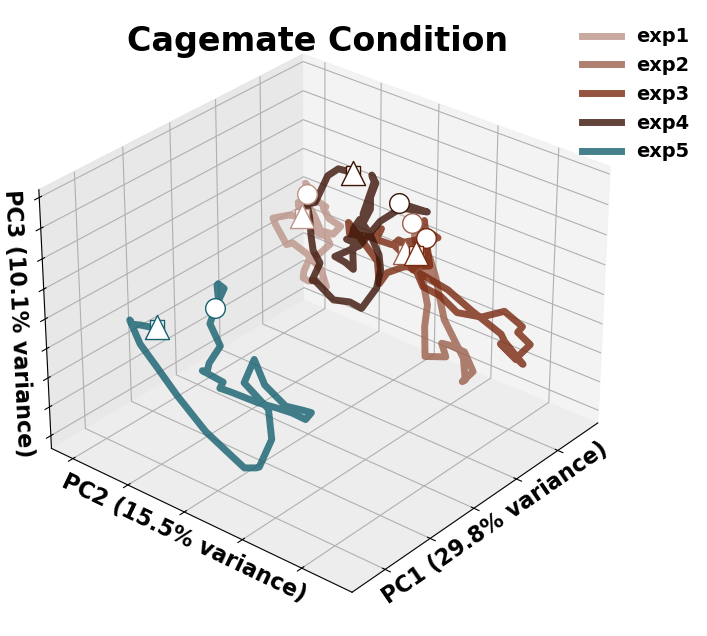

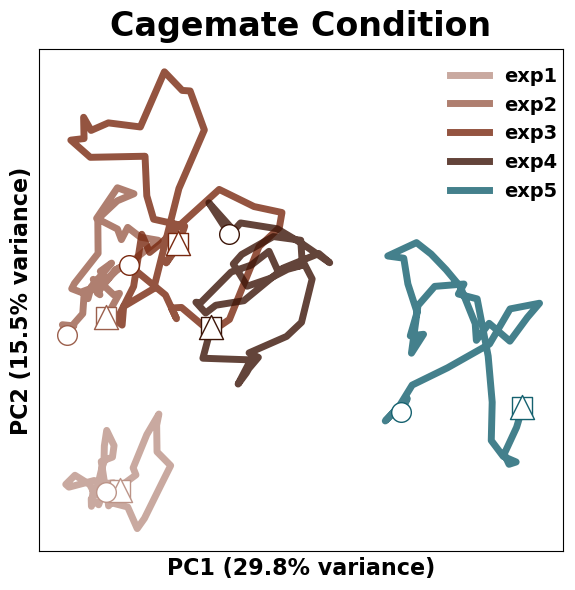

PCA Result with:
Events: exp1, exp2, exp3, exp4, exp5
Timebins per event: 40.0
Total neurons: 131
Number of recordings: 9
Number of Pcs needed to explain 90% of variance 15
PCA Result with:
Events: exp1, exp2, exp3, exp4, exp5
Timebins per event: 40.0
Total neurons: 130
Number of recordings: 9
Number of Pcs needed to explain 90% of variance 8


C:\Users\megha\AppData\Local\Temp\ipykernel_6932\4153481633.py:83: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


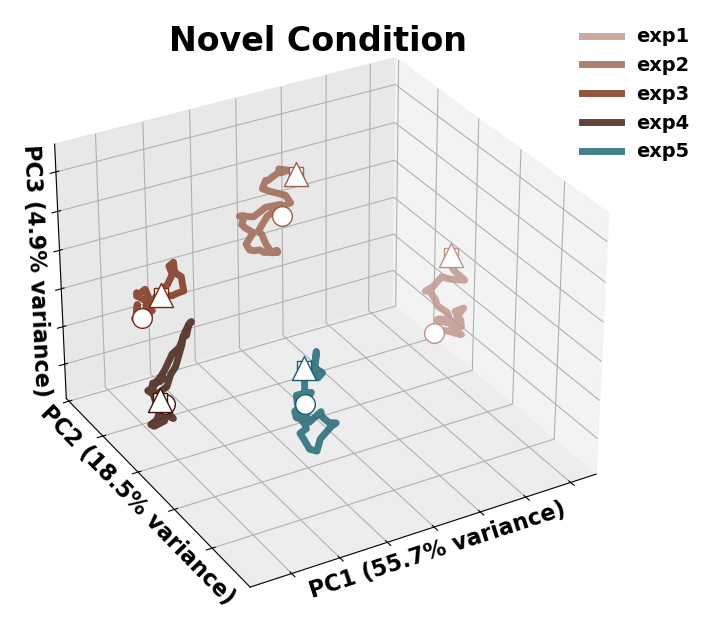

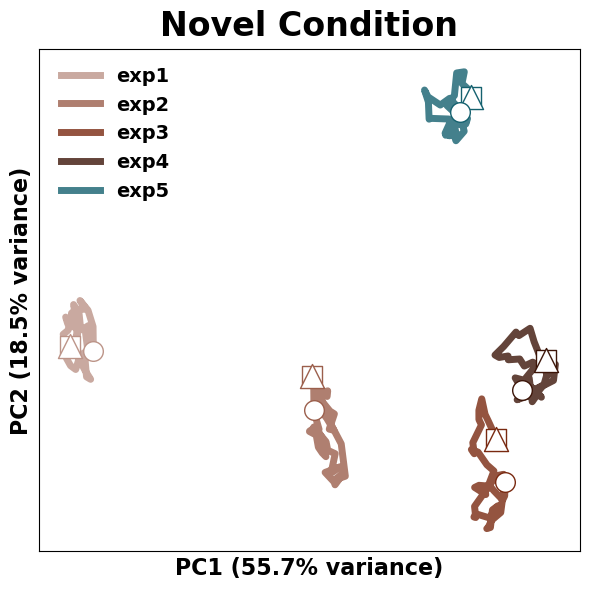

In [ ]:
cagemate_pca_results = pca_trajectories.avg_trajectories_pca(cagemate_collection, 3, 1, events = ['exp1', 'exp2', 'exp3', 'exp4', 'exp5'],min_neurons=5, plot = False)
novel_pca_results = pca_trajectories.avg_trajectories_pca(novel_collection, 3, 1, events = ['exp1', 'exp2', 'exp3', 'exp4', 'exp5'],min_neurons=5, plot = False)

exp_colors = [hex_2_rgb('#bc9488'),
              hex_2_rgb('#9b5f4c'),
              hex_2_rgb('#792910'),
              hex_2_rgb('#3c1508'),
              hex_2_rgb('#15616F')]
plot_pca_results_3d(cagemate_pca_results, "Cagemate Condition", exp_colors, azim = 40, elev = 30)
plot_pca_results_2d(cagemate_pca_results, "Cagemate Condition", colors = exp_colors, legend_spot = (0.75, 1))
print(cagemate_pca_results)
print(novel_pca_results)
plot_pca_results_3d(novel_pca_results, "Novel Condition", exp_colors, azim = 60, elev = 30)
plot_pca_results_2d(novel_pca_results, "Novel Condition", colors = exp_colors, legend_spot = (.01, 1))

Excluding 33_nov_p1_merged.rec with 1 neurons


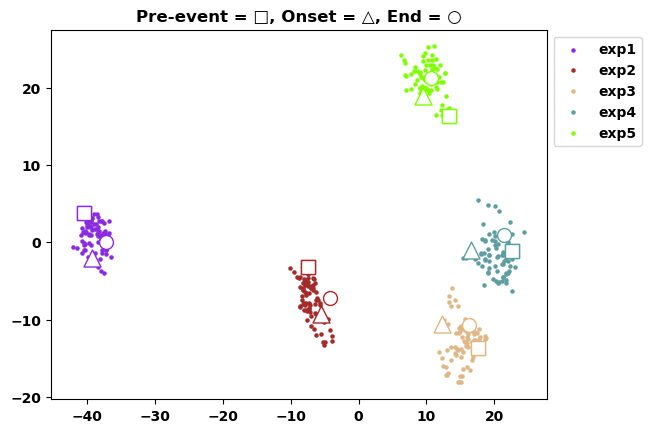

10


In [ ]:
novel_pc_dict = pca_trajectories.avg_trajectories_pca(novel_collection, 5, 3, min_neurons=5, plot = True)
var = novel_pc_dict['explained variance']
total_var = 0
for i in range(len(novel_pc_dict['explained variance'])):
    total_var = total_var + novel_pc_dict['explained variance'][i]
    if total_var > .9:
        print(i)
        break

In [ ]:
import importlib
importlib.reload(pca_trajectories)
cagemate_collection.analyze(timebin = 50, ignore_freq = 0.5)
geo_dist = pca_trajectories.avg_geo_dist(cagemate_collection, 3, 1, percent_var=90, post_window=0, min_neurons = 5)
geo_dist

All set to analyze


,baseline_exp1,baseline_exp2,baseline_exp3,baseline_exp4,baseline_exp5,exp1_exp2,exp1_exp3,exp1_exp4,exp1_exp5,exp2_exp3,exp2_exp4,exp2_exp5,exp3_exp4,exp3_exp5,exp4_exp5
11_cage_p1_merged.rec,1689.086063,1750.596252,1988.225916,1616.942029,2242.907146,1349.647618,1364.400262,1205.662695,1715.451194,1668.557085,1366.390019,1892.344172,1572.610624,2016.995343,1879.453300
12_cage_p1_merged.rec,880.730059,1145.290152,1046.520231,1158.267034,964.957101,851.603326,743.618360,787.999578,712.831105,816.046505,789.788408,852.854807,694.668593,760.499940,788.536741
13_cage_p1_merged.rec,1234.155374,1748.527432,1601.590603,1627.254357,1951.467656,1401.409032,1239.088806,1295.768649,1363.501192,1604.817489,1656.555162,1511.490231,1518.333176,1465.581003,1587.973032
21_cage_p1_merged.rec,1386.339387,1316.818001,1368.507408,1579.787229,1461.227059,1001.646306,1022.396069,940.671313,902.961398,1030.339389,1104.633273,1120.749342,1094.755954,1091.397402,953.743492
22_cage_p1_merged.rec,1217.846217,1251.192820,1370.857687,1249.845247,1413.957815,777.167476,1021.982793,1134.540807,1129.755586,937.401672,1165.472630,1148.044118,1215.009707,1282.457642,1291.221015
24_cage_p1_merged.rec,1939.613461,2374.351606,3022.821650,2681.409344,2688.148976,1704.629047,2272.078599,1785.510338,2000.282893,1801.194968,1579.438749,1779.520273,1851.112210,2124.243808,1721.571751
32_cage_p1_merged.rec,1433.868385,1455.153892,1775.510553,1398.189689,1386.806421,1380.567277,1673.815223,1508.715052,1525.008234,1731.229111,1595.400720,1556.316069,1799.494379,1786.732696,1372.587399
41_cage_p1_merged.rec,956.540474,957.392926,1083.007850,1119.550139,1372.614754,795.624099,922.158013,856.163326,1106.115872,893.167398,871.189465,1139.863619,935.603352,1055.574405,957.718263
44_cage_p1_merged.rec,2707.675616,3054.448547,3582.465765,3966.325359,4430.841092,2200.260972,2817.209150,2912.319172,3120.707370,2567.889388,2837.393099,3131.444724,3159.780294,3396.868725,3325.286321


In [ ]:
from importlib import reload
reload(pca_trajectories)
novel_collection.analyze(timebin = 100, ignore_freq = 0.5, smoothing_window=500)
geo_dist = pca_trajectories.avg_geo_dist(novel_collection, events = ['exp1', 'exp2', 'exp3', 'exp4', 'exp5'], event_length=3, pre_window=1, percent_var=90, post_window=0, min_neurons = 5)
avg_vals_df = geo_dist.mean()
avg_vals = avg_vals_df.values.tolist()
avg_sems = geo_dist.sem()
avg_sems = avg_sems.values.tolist()
geo_dist


All set to analyze


,exp1_exp2,exp1_exp3,exp1_exp4,exp1_exp5,exp2_exp3,exp2_exp4,exp2_exp5,exp3_exp4,exp3_exp5,exp4_exp5
11_nov_p1_merged.rec,573.980349,755.266514,805.074686,631.309873,289.624179,388.510733,333.524078,254.604408,308.017281,316.569582
12_nov_p1_merged.rec,197.885621,323.731092,381.614667,209.759302,297.419210,349.295425,227.013933,299.507563,344.657092,418.574059
13_nov_p1_merged.rec,653.761568,669.421546,501.885905,588.610834,141.056326,312.874998,457.737247,317.714019,463.924420,273.920535
21_nov_p1_merged.rec,203.891653,375.209056,397.132839,449.363507,312.327362,361.356549,414.456098,301.475269,309.442452,298.436820
22_nov_p1_merged.rec,377.724877,426.456720,441.522036,327.732036,269.166104,325.821729,356.730095,218.043746,276.117959,222.431902
24_nov_p1_merged.rec,437.989190,448.783647,501.882231,425.911089,333.858683,316.236509,538.174009,399.761963,527.350373,553.849636
32_nov_p1_merged.rec,392.144920,487.623089,470.658999,382.977318,382.773552,358.321054,499.187793,276.074672,564.490143,521.443448
41_nov_p1_merged.rec,806.055389,1275.430448,1552.931940,1555.655509,620.311388,838.932139,899.372285,433.968426,589.141309,474.651839
44_nov_p1_merged.rec,719.900006,1380.677757,1377.561188,1067.551324,776.197000,736.922037,709.164992,473.787307,963.569638,786.604125


In [ ]:
novel_geo_dist = pca_trajectories.avg_geo_dist(novel_collection, events = ['exp1', 'exp2', 'exp3', 'exp4', 'exp5'], event_length=3, pre_window=1, percent_var=90, post_window=0, min_neurons = 5)
novel_geo_dist
avg_vals_df = novel_geo_dist.mean()
avg_vals_df

exp1_exp2    484.814842
exp1_exp3    682.511096
exp1_exp4    714.473832
exp1_exp5    626.541199
exp2_exp3    380.303756
exp2_exp4    443.141241
exp2_exp5    492.817837
exp3_exp4    330.548597
exp3_exp5    482.967852
exp4_exp5    429.609105
dtype: float64

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
def create_comparison_matrix(df):
    # Get unique experiments
    experiments = sorted(list(set([exp for col in df.columns for exp in col.split('_')])))
    n = len(experiments)
    
    # Create empty matrix
    matrix = np.zeros((n, n))
    
    # Fill matrix
    for i, exp1 in enumerate(experiments):
        for j, exp2 in enumerate(experiments):
            if i == j:
                matrix[i,j] = 1
            else:
                col1 = f"{exp1}_{exp2}"
                col2 = f"{exp2}_{exp1}"
                if col1 in df.columns:
                    matrix[i,j] = df[col1].mean()
                elif col2 in df.columns:
                    matrix[i,j] = df[col2].mean()
    
    return pd.DataFrame(matrix, index=experiments, columns=experiments)

def plot_comparison_heatmap(df, title, color, diagonal_color, vmin):
    # Create comparison matrix
    matrix = create_comparison_matrix(df)
    
    # Create figure
    plt.figure(figsize=(5, 4))
    n_bins = 100  # Number of color gradients
    cmap = LinearSegmentedColormap.from_list('custom', color, N=n_bins)
    # Create heatmap
    sns.heatmap(matrix, 
                annot=True, 
                cmap=cmap,
                fmt='.0f',
                square=True,
                cbar_kws={'label': 'AU Distance'},
                vmin = vmin)
    for i in range(len(matrix)):
        plt.plot(i + 0.5, i + 0.5, 'o', color=diagonal_color, markersize=25, zorder =100)
    
    plt.title(title, fontsize = 16)
    plt.tight_layout()
    return plt



<module 'matplotlib.pyplot' from 'c:\\Users\\megha\\anaconda3\\envs\\lfp_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

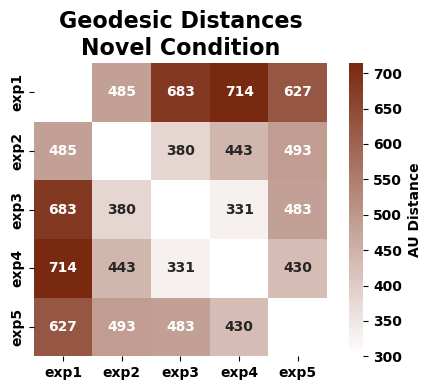

In [ ]:
plot_comparison_heatmap(novel_geo_dist, title = "Geodesic Distances\nNovel Condition", color = ['white', '#792910'], diagonal_color='white', vmin = 300)

In [ ]:
avg_vals = np.array(avg_vals_df.values.tolist())
avg_vals = avg_vals[[2, 3, 9]]
avg_sems = geo_dist.sem()

avg_sems = np.array(avg_sems.values.tolist())
avg_sems = avg_sems[[2,3,9]]

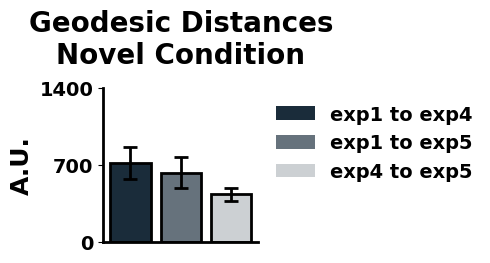

In [ ]:

color_id_dict = {'exp1 to exp4': hex_2_rgb('#1a2c3a'),  
                'exp1 to exp5': hex_2_rgb('#66727c'),
                'exp4 to exp5': hex_2_rgb('#ccd0d3')
                }
hatches = ['','','']  
plt.figure(figsize= (2,2))           
plt.bar(color_id_dict.keys(), avg_vals, yerr = avg_sems,
            color = color_id_dict.values(), hatch = hatches,
            edgecolor = ['black', 'black', 'black'],
            capsize = 5, linewidth = 2, error_kw={'elinewidth': 2, 'capthick': 2})
plt.xticks([],rotation=45)
legend_handles = [Patch(facecolor=color, label=label) for label, color in color_id_dict.items()]
plt.legend(handles=legend_handles,
           bbox_to_anchor=(1,1),
           frameon= False, fontsize = 14)
plt.ylabel('A.U.', fontsize = 18)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(700))
plt.ylim(0,1400)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
hatches = ['//','','','', '']
plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
plt.gca().spines['left'].set_linewidth(2) 
plt.title('Geodesic Distances\nNovel Condition', fontsize = 20, y =1.1)
plt.show()

In [ ]:
geo_dist = pca_trajectories.avg_geo_dist(cagemate_collection, events = ['exp1', 'exp2', 'exp3', 'exp4', 'exp5'], event_length=3, pre_window=1, percent_var=90, post_window=0, min_neurons = 5)
geo_dist
avg_vals_df = geo_dist.mean()
avg_vals_df

exp1_exp2    1273.617239
exp1_exp3    1452.971919
exp1_exp4    1380.816770
exp1_exp5    1508.512761
exp2_exp3    1450.071445
exp2_exp4    1440.695725
exp2_exp5    1570.291928
exp3_exp4    1537.929810
exp3_exp5    1664.483440
exp4_exp5    1542.010146
dtype: float64

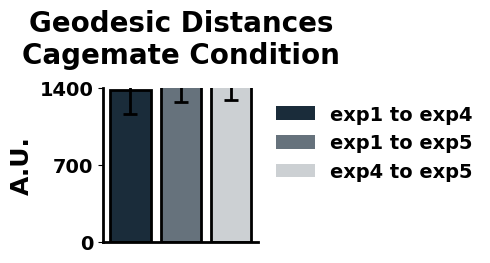

In [ ]:
avg_vals = np.array(avg_vals_df.values.tolist())
avg_vals = avg_vals[[2, 3, 9]]
avg_sems = geo_dist.sem()

avg_sems = np.array(avg_sems.values.tolist())
avg_sems = avg_sems[[2,3,9]]
color_id_dict = {'exp1 to exp4': hex_2_rgb('#1a2c3a'),  
                'exp1 to exp5': hex_2_rgb('#66727c'),
                'exp4 to exp5': hex_2_rgb('#ccd0d3')
                }
hatches = ['','','']  
plt.figure(figsize= (2,2))           
plt.bar(color_id_dict.keys(), avg_vals, yerr = avg_sems,
            color = color_id_dict.values(), hatch = hatches,
            edgecolor = ['black', 'black', 'black'],
            capsize = 5, linewidth = 2, error_kw={'elinewidth': 2, 'capthick': 2})
plt.xticks([],rotation=45)
legend_handles = [Patch(facecolor=color, label=label) for label, color in color_id_dict.items()]
plt.legend(handles=legend_handles,
           bbox_to_anchor=(1,1),
           frameon= False, fontsize = 14)
plt.ylabel('A.U.', fontsize = 18)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(700))
plt.ylim(0,1400)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
hatches = ['//','','','', '']
plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
plt.gca().spines['left'].set_linewidth(2) 
plt.title('Geodesic Distances\nCagemate Condition', fontsize = 20, y =1.1)
plt.show()

<module 'matplotlib.pyplot' from 'c:\\Users\\megha\\anaconda3\\envs\\lfp_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

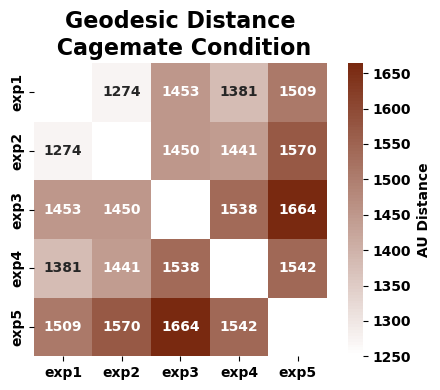

In [ ]:
plot_comparison_heatmap(geo_dist, title = "Geodesic Distance\n Cagemate Condition", color = ['white', '#792910'], diagonal_color='white', vmin = 1250)


In [ ]:

dimensionality = []
for recording in novel_collection.collection:
    pca_trajectories.avg_trajectories_pca(recording, events = ['exp1', 'exp5'], event_length=5, pre_window = 3, min_neurons=5, plot = False)
    total_var = 0
    for i in range(len(novel_pc_dict['explained variance'])):
        total_var = total_var + novel_pc_dict['explained variance'][i]
        if total_var > .9:
            dimensionality.append(i)
            break
            

print(np.mean(np.array(dimensionality)))

Excluding 33_nov_p1_merged.rec with 1 neurons
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
4.0


In [ ]:
dimensionality = []
for recording in novel_collection.collection:
    novel_pc_dict = pca_trajectories.avg_trajectories_pca(recording, events = ['exp1', 'exp2', 'exp3', 'exp4', 'exp5'], event_length=3, pre_window = 1, min_neurons=5, plot = False)
    total_var = 0
    if novel_pc_dict:
        for i in range(len(novel_pc_dict['explained variance'])):
            total_var = total_var + novel_pc_dict['explained variance'][i]
            if total_var > .9:
                dimensionality.append(i)
                break
            

print(np.mean(np.array(dimensionality)))

Excluding 33_nov_p1_merged.rec with 1 neurons
2.888888888888889


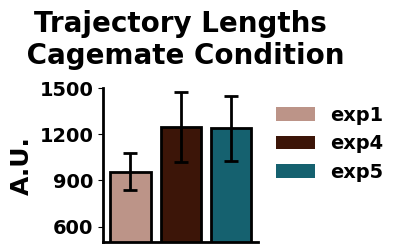

,Comparison,t_statistic,p_value,p_adjusted,significant
0,exp1_exp4,-2.363471,0.045710,0.137130,False
1,exp1_exp5,-2.219534,0.057224,0.137130,False
2,exp4_exp5,0.094186,0.927278,0.927278,False


In [ ]:
from scipy.spatial.distance import euclidean
from statsmodels.stats.multitest import multipletests
def trajectory_length(pca_matrix, key):
    trajectory_lengths = []
    event_order = []
    unique_values, counts = np.unique(key, return_counts=True)
    event_len = counts[0]
    for j in range(0, len(key), event_len):
        trajectory_length = 0
        for i in range(event_len-1):
            trajectory_length = trajectory_length + euclidean(
                pca_matrix[j+i, :],
                pca_matrix[j+i+1, :])
        trajectory_lengths.append(trajectory_length)
        event_order.append(key[j])
    return [trajectory_lengths, event_order]

trajectory_lengths = []
orders= []
for recording in cagemate_collection.collection:
    pc_result = pca_trajectories.avg_trajectories_pca(recording, event_length = 3, pre_window = 1,
                                                 events = ['exp1',
                                                           'exp2',
                                                            'exp3',
                                                           'exp4',
                                                           'exp5'], min_neurons=5, plot = False)
    if pc_result:
        [traj_len, event_order] = trajectory_length(pc_result.transformed_data, pc_result.labels)
        trajectory_lengths.append(traj_len)
        orders.append(event_order)
trajectory_lengths = np.array(trajectory_lengths)



means = np.mean(trajectory_lengths, axis = 0)
sems = sem(trajectory_lengths, axis = 0)
means_for_plotting = means[[0,3,4]]
sems_for_plotting = sems[[0,3,4]]

t_exp1_exp4, p_exp1_exp4 = stats.ttest_rel(trajectory_lengths[:,0], trajectory_lengths[:,3])
t_exp1_exp5, p_exp1_exp5 = stats.ttest_rel(trajectory_lengths[:,0], trajectory_lengths[:,4])
t_exp4_exp5, p_exp4_exp5 = stats.ttest_rel(trajectory_lengths[:,3], trajectory_lengths[:,4])
p_values = [p_exp1_exp4, p_exp1_exp5, p_exp4_exp5]
reject, p_adjusted, _, _ = multipletests(p_values, method='holm')
stats_df = pd.DataFrame({
   'Comparison': ['exp1_exp4', 'exp1_exp5', 'exp4_exp5'],
   't_statistic': [t_exp1_exp4, t_exp1_exp5, t_exp4_exp5],
   'p_value': p_values,
   'p_adjusted': p_adjusted,
   'significant': reject
})

# Adjust p-values using Holm-Bonferroni
p_values = [p_exp1_exp4, p_exp1_exp5, p_exp4_exp5]
reject, p_adjusted, _, _ = multipletests(p_values, method='holm')
color_id_dict = {'exp1': hex_2_rgb('#bc9488'), 
                'exp4': hex_2_rgb('#3c1508'),
                  'exp5':  hex_2_rgb('#15616F')}
hatches = ['','','']  
x = [0.5,1,1.5]
plt.figure(figsize= (2,2))           
plt.bar(x, means_for_plotting, yerr = sems_for_plotting,
            color = color_id_dict.values(), hatch = hatches,
            edgecolor = ['black', 'black', 'black'],
            capsize = 5, linewidth = 2,
            error_kw={'elinewidth': 2, 'capthick': 2}, 
            width = .4)
plt.xticks([],rotation=45)
legend_handles = [Patch(facecolor=color, label=label) for label, color in color_id_dict.items()]
plt.legend(handles=legend_handles,
           bbox_to_anchor=(1,1),
           frameon= False, fontsize = 14)
plt.ylabel('A.U.', fontsize = 18)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(300))
plt.ylim(500,1500)
hatches = ['//','','','', '']
plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
plt.gca().spines['left'].set_linewidth(2) 
plt.title('Trajectory Lengths\n Cagemate Condition', fontsize = 20, y = 1.1)
plt.show()

stats_df


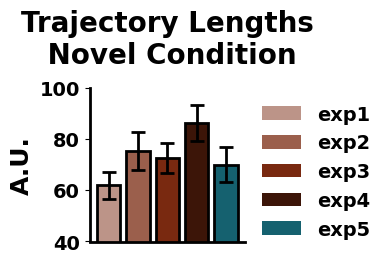

,Comparison,t_statistic,p_value,p_adjusted,significant
0,exp1_exp4,-3.086491,0.014969,0.044907,True
1,exp1_exp5,-1.960923,0.085536,0.085536,False
2,exp4_exp5,2.530445,0.035231,0.070462,False


In [ ]:
def trajectory_length(pca_matrix, key):
    trajectory_lengths = []
    event_order = []
    unique_values, counts = np.unique(key, return_counts=True)
    event_len = counts[0]
    for j in range(0, len(key), event_len):
        trajectory_length = 0
        for i in range(event_len-1):
            trajectory_length = trajectory_length + euclidean(
                pca_matrix[j+i, :],
                pca_matrix[j+i+1, :])
        trajectory_lengths.append(trajectory_length)
        event_order.append(key[j])
    return [trajectory_lengths, event_order]

trajectory_lengths = []
orders= []
for recording in novel_collection.collection:
    pc_result = pca_trajectories.avg_trajectories_pca(recording, event_length = 3, pre_window = 1,
                                                 events = ['exp1',
                                                           'exp2',
                                                            'exp3',
                                                           'exp4',
                                                           'exp5'], min_neurons=5, plot = False)
    if pc_result:
        [traj_len, event_order] = trajectory_length(pc_result.transformed_data, pc_result.labels)
        trajectory_lengths.append(traj_len)
        orders.append(event_order)
trajectory_lengths = np.array(trajectory_lengths)



means = np.mean(trajectory_lengths, axis = 0)
sems = sem(trajectory_lengths, axis = 0)

t_exp1_exp4, p_exp1_exp4 = stats.ttest_rel(trajectory_lengths[:,0], trajectory_lengths[:,3])
t_exp1_exp5, p_exp1_exp5 = stats.ttest_rel(trajectory_lengths[:,0], trajectory_lengths[:,4])
t_exp4_exp5, p_exp4_exp5 = stats.ttest_rel(trajectory_lengths[:,3], trajectory_lengths[:,4])
p_values = [p_exp1_exp4, p_exp1_exp5, p_exp4_exp5]
reject, p_adjusted, _, _ = multipletests(p_values, method='holm')
stats_df = pd.DataFrame({
   'Comparison': ['exp1_exp4', 'exp1_exp5', 'exp4_exp5'],
   't_statistic': [t_exp1_exp4, t_exp1_exp5, t_exp4_exp5],
   'p_value': p_values,
   'p_adjusted': p_adjusted,
   'significant': reject
})

# Adjust p-values using Holm-Bonferroni
p_values = [p_exp1_exp4, p_exp1_exp5, p_exp4_exp5]
reject, p_adjusted, _, _ = multipletests(p_values, method='holm')
color_id_dict = {'exp1': hex_2_rgb('#bc9488'), 
                 'exp2' :hex_2_rgb('#9b5f4c'),
                 'exp3': hex_2_rgb('#792910'),
                'exp4': hex_2_rgb('#3c1508'),
                  'exp5':  hex_2_rgb('#15616F')}
hatches = ['','','', '', '']  
x = [0, 0.5,1,1.5, 2]
plt.figure(figsize= (2,2))           
plt.bar(x, means, yerr = sems,
            color = color_id_dict.values(), hatch = hatches,
            edgecolor = ['black', 'black', 'black', 'black', 'black'],
            capsize = 5, linewidth = 2,
            error_kw={'elinewidth': 2, 'capthick': 2}, 
            width = .4)
plt.xticks([],rotation=45)
legend_handles = [Patch(facecolor=color, label=label) for label, color in color_id_dict.items()]
plt.legend(handles=legend_handles,
           bbox_to_anchor=(1,1),
           frameon= False, fontsize = 14)
plt.ylabel('A.U.', fontsize = 18)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(20))
plt.ylim(40,100)
hatches = ['//','','','', '']
plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
plt.gca().spines['left'].set_linewidth(2) 
plt.title('Trajectory Lengths\n Novel Condition', fontsize = 20, y = 1.1)
plt.show()

stats_df

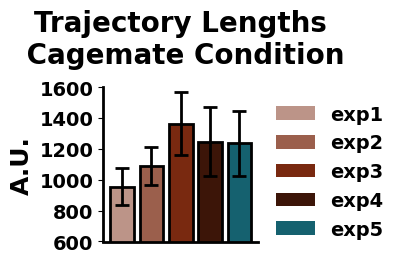

In [ ]:
def trajectory_length(pca_matrix, key):
    trajectory_lengths = []
    event_order = []
    unique_values, counts = np.unique(key, return_counts=True)
    event_len = counts[0]
    for j in range(0, len(key), event_len):
        trajectory_length = 0
        for i in range(event_len-1):
            trajectory_length = trajectory_length + euclidean(
                pca_matrix[j+i, :],
                pca_matrix[j+i+1, :])
        trajectory_lengths.append(trajectory_length)
        event_order.append(key[j])
    return [trajectory_lengths, event_order]

trajectory_lengths = []
orders= []
for recording in cagemate_collection.collection:
    pc_result = pca_trajectories.avg_trajectories_pca(recording, event_length = 3, pre_window = 1,
                                                 events = ['exp1',
                                                           'exp2',
                                                            'exp3',
                                                           'exp4',
                                                           'exp5'], min_neurons=5, plot = False)
    if pc_result:
        [traj_len, event_order] = trajectory_length(pc_result.transformed_data, pc_result.labels)
        trajectory_lengths.append(traj_len)
        orders.append(event_order)
trajectory_lengths = np.array(trajectory_lengths)



means = np.mean(trajectory_lengths, axis = 0)
sems = sem(trajectory_lengths, axis = 0)

t_exp1_exp4, p_exp1_exp4 = stats.ttest_rel(trajectory_lengths[:,0], trajectory_lengths[:,3])
t_exp1_exp5, p_exp1_exp5 = stats.ttest_rel(trajectory_lengths[:,0], trajectory_lengths[:,4])
t_exp4_exp5, p_exp4_exp5 = stats.ttest_rel(trajectory_lengths[:,3], trajectory_lengths[:,4])
p_values = [p_exp1_exp4, p_exp1_exp5, p_exp4_exp5]
reject, p_adjusted, _, _ = multipletests(p_values, method='holm')
stats_df = pd.DataFrame({
   'Comparison': ['exp1_exp4', 'exp1_exp5', 'exp4_exp5'],
   't_statistic': [t_exp1_exp4, t_exp1_exp5, t_exp4_exp5],
   'p_value': p_values,
   'p_adjusted': p_adjusted,
   'significant': reject
})

# Adjust p-values using Holm-Bonferroni
p_values = [p_exp1_exp4, p_exp1_exp5, p_exp4_exp5]
reject, p_adjusted, _, _ = multipletests(p_values, method='holm')
color_id_dict = {'exp1': hex_2_rgb('#bc9488'), 
                 'exp2' :hex_2_rgb('#9b5f4c'),
                 'exp3': hex_2_rgb('#792910'),
                'exp4': hex_2_rgb('#3c1508'),
                  'exp5':  hex_2_rgb('#15616F')}
hatches = ['','','', '', '']  
x = [0, 0.5,1,1.5, 2]
plt.figure(figsize= (2,2))           
plt.bar(x, means, yerr = sems,
            color = color_id_dict.values(), hatch = hatches,
            edgecolor = ['black', 'black', 'black', 'black', 'black'],
            capsize = 5, linewidth = 2,
            error_kw={'elinewidth': 2, 'capthick': 2}, 
            width = .4)
plt.xticks([],rotation=45)
legend_handles = [Patch(facecolor=color, label=label) for label, color in color_id_dict.items()]
plt.legend(handles=legend_handles,
           bbox_to_anchor=(1,1),
           frameon= False, fontsize = 14)
plt.ylabel('A.U.', fontsize = 18)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(200))
plt.ylim(600,1600)
hatches = ['//','','','', '']
plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
plt.gca().spines['left'].set_linewidth(2) 
plt.title('Trajectory Lengths\n Cagemate Condition', fontsize = 20, y = 1.1)
plt.show()

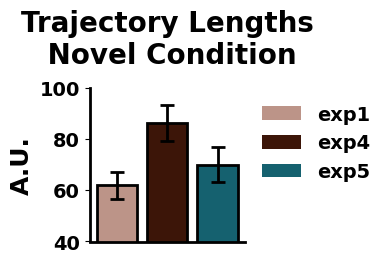

,Comparison,t_statistic,p_value,p_adjusted,significant
0,exp1_exp4,-3.086491,0.014969,0.044907,True
1,exp1_exp5,-1.960923,0.085536,0.085536,False
2,exp4_exp5,2.530445,0.035231,0.070462,False


In [ ]:
from scipy.spatial.distance import euclidean
from statsmodels.stats.multitest import multipletests
def trajectory_length(pca_matrix, key):
    trajectory_lengths = []
    event_order = []
    unique_values, counts = np.unique(key, return_counts=True)
    event_len = counts[0]
    for j in range(0, len(key), event_len):
        trajectory_length = 0
        for i in range(event_len-1):
            trajectory_length = trajectory_length + euclidean(
                pca_matrix[j+i, :],
                pca_matrix[j+i+1, :])
        trajectory_lengths.append(trajectory_length)
        event_order.append(key[j])
    return [trajectory_lengths, event_order]

trajectory_lengths = []
orders= []
for recording in novel_collection.collection:
    pc_result = pca_trajectories.avg_trajectories_pca(recording, event_length = 3, pre_window = 1,
                                                 events = ['exp1',
                                                           'exp2',
                                                            'exp3',
                                                           'exp4',
                                                           'exp5'], min_neurons=5, plot = False)
    if pc_result:
        [traj_len, event_order] = trajectory_length(pc_result.transformed_data, pc_result.labels)
        trajectory_lengths.append(traj_len)
        orders.append(event_order)
trajectory_lengths = np.array(trajectory_lengths)



means = np.mean(trajectory_lengths, axis = 0)
sems = sem(trajectory_lengths, axis = 0)
means_for_plotting = means[[0,3,4]]
sems_for_plotting = sems[[0,3,4]]

t_exp1_exp4, p_exp1_exp4 = stats.ttest_rel(trajectory_lengths[:,0], trajectory_lengths[:,3])
t_exp1_exp5, p_exp1_exp5 = stats.ttest_rel(trajectory_lengths[:,0], trajectory_lengths[:,4])
t_exp4_exp5, p_exp4_exp5 = stats.ttest_rel(trajectory_lengths[:,3], trajectory_lengths[:,4])
p_values = [p_exp1_exp4, p_exp1_exp5, p_exp4_exp5]
reject, p_adjusted, _, _ = multipletests(p_values, method='holm')
stats_df = pd.DataFrame({
   'Comparison': ['exp1_exp4', 'exp1_exp5', 'exp4_exp5'],
   't_statistic': [t_exp1_exp4, t_exp1_exp5, t_exp4_exp5],
   'p_value': p_values,
   'p_adjusted': p_adjusted,
   'significant': reject
})

# Adjust p-values using Holm-Bonferroni
p_values = [p_exp1_exp4, p_exp1_exp5, p_exp4_exp5]
reject, p_adjusted, _, _ = multipletests(p_values, method='holm')
color_id_dict = {'exp1': hex_2_rgb('#bc9488'), 
                'exp4': hex_2_rgb('#3c1508'),
                  'exp5':  hex_2_rgb('#15616F')}
hatches = ['','','']  
x = [0.5,1,1.5]
plt.figure(figsize= (2,2))           
plt.bar(x, means_for_plotting, yerr = sems_for_plotting,
            color = color_id_dict.values(), hatch = hatches,
            edgecolor = ['black', 'black', 'black'],
            capsize = 5, linewidth = 2,
            error_kw={'elinewidth': 2, 'capthick': 2}, 
            width = .4)
plt.xticks([],rotation=45)
legend_handles = [Patch(facecolor=color, label=label) for label, color in color_id_dict.items()]
plt.legend(handles=legend_handles,
           bbox_to_anchor=(1,1),
           frameon= False, fontsize = 14)
plt.ylabel('A.U.', fontsize = 18)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(20))
plt.ylim(40,100)
hatches = ['//','','','', '']
plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
plt.gca().spines['left'].set_linewidth(2) 
plt.title('Trajectory Lengths\n Novel Condition', fontsize = 20, y = 1.1)
plt.show()

stats_df

In [ ]:

dimensionality = []
for recording in cagemate_collection.collection:
    cagemate_pc_dict = pca_trajectories.avg_trajectories_pca(recording, events = ['exp1', 'exp2', 'exp3', 'exp4', 'exp5'], event_length=3, pre_window = 1, min_neurons=5, plot = False)
    total_var = 0
    if cagemate_pc_dict:
        for i in range(len(cagemate_pc_dict['explained variance'])):
            total_var = total_var + cagemate_pc_dict['explained variance'][i]
            if total_var > .9:
                dimensionality.append(i)
                break
            

print(np.mean(np.array(dimensionality)))

Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons
4.222222222222222


Excluding 33_nov_p1_merged.rec with 1 neurons


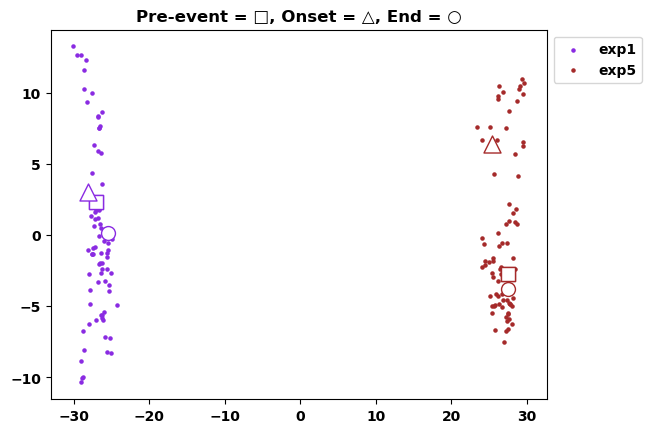

3


In [ ]:
novel_pc_dict = pca_trajectories.avg_trajectories_pca(novel_collection, events = ['exp1', 'exp5'], event_length=5, pre_window = 3, min_neurons=5, plot = True)
var = novel_pc_dict['explained variance']
total_var = 0
for i in range(len(novel_pc_dict['explained variance'])):
    total_var = total_var + novel_pc_dict['explained variance'][i]
    if total_var > .9:
        print(i)
        break

In [56]:
for recording in novel_collection.collection:
    novel = np.concatenate([recording.event_dict['exp1'], recording.event_dict['exp5']], axis = 0)
    recording.event_dict['novel'] = novel
    not_novel = np.concatenate([recording.event_dict['exp3'], recording.event_dict['exp4']], axis = 0)
    recording.event_dict['not_novel'] = not_novel
for recording in cagemate_collection.collection:
    novel = np.concatenate([recording.event_dict['exp1'], recording.event_dict['exp5']], axis = 0)
    recording.event_dict['novel'] = novel
    not_novel = np.concatenate([recording.event_dict['exp3'], recording.event_dict['exp4']], axis = 0)
    recording.event_dict['not_novel'] = not_novel

Excluding 33_nov_p1_merged.rec with 1 neurons


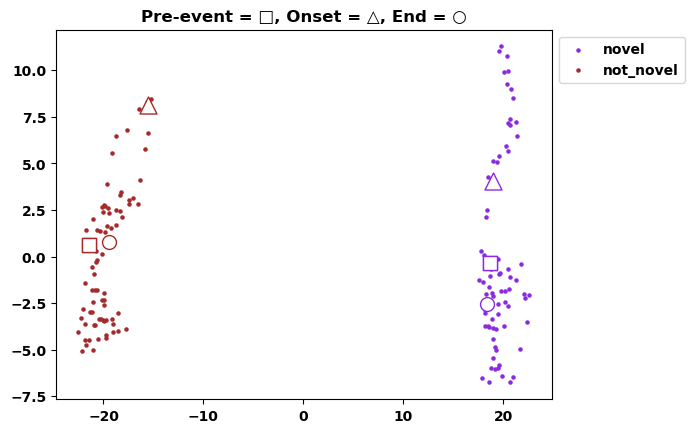

4


In [ ]:
novel_pc_dict = pca_trajectories.avg_trajectories_pca(novel_collection, events = ['novel', 'not_novel'], event_length=5, pre_window = 3, min_neurons=5, plot = True)
var = novel_pc_dict['explained variance']
total_var = 0
for i in range(len(novel_pc_dict['explained variance'])):
    total_var = total_var + novel_pc_dict['explained variance'][i]
    if total_var > .9:
        print(i)
        break

Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons


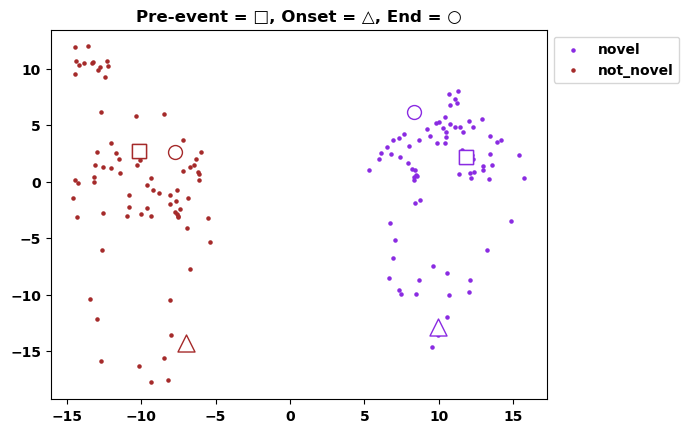

13


In [ ]:
cagemate_pc_dict = pca_trajectories.avg_trajectories_pca(cagemate_collection, events = ['novel', 'not_novel'], event_length=5, pre_window = 3, min_neurons=5, plot = True)
var = cagemate_pc_dict['explained variance']
total_var = 0
for i in range(len(cagemate_pc_dict['explained variance'])):
    total_var = total_var + cagemate_pc_dict['explained variance'][i]
    if total_var > .9:
        print(i)
        break

In [70]:
cagemate_collection = unpickle_this('cagemate_collection.pkl')
novel_collection = unpickle_this('novel_collection.pkl')

In [71]:


whole_collection = cagemate_collection

In [72]:

for recording in novel_collection.collection:
    whole_collection.collection.append(recording)


In [73]:
print(len(whole_collection.collection))

21


In [74]:
for recording in whole_collection.collection:
    print(recording.name)

11_cage_p1_merged.rec
12_cage_p1_merged.rec
13_cage_p1_merged.rec
21_cage_p1_merged.rec
22_cage_p1_merged.rec
24_cage_p1_merged.rec
31_cage_p1_merged.rec
32_cage_p1_merged.rec
33_cage_p1_merged.rec
41_cage_p1_merged.rec
44_cage_p1_merged.rec
11_nov_p1_merged.rec
12_nov_p1_merged.rec
13_nov_p1_merged.rec
21_nov_p1_merged.rec
22_nov_p1_merged.rec
24_nov_p1_merged.rec
32_nov_p1_merged.rec
33_nov_p1_merged.rec
41_nov_p1_merged.rec
44_nov_p1_merged.rec


In [75]:
for recording in whole_collection.collection:
    novel = np.concatenate([recording.event_dict['exp1'], recording.event_dict['exp5']], axis = 0)
    recording.event_dict['novel'] = novel
    not_novel = np.concatenate([recording.event_dict['exp3'], recording.event_dict['exp4']], axis = 0)
    recording.event_dict['not_novel'] = not_novel

In [76]:
condition_dict = {"cagemate": [], "novel": []}
for recording in whole_collection.collection:
    if "cage" in recording.name:
        condition_dict["cagemate"].append(recording.name)
    if "nov" in recording.name:
        condition_dict["novel"].append(recording.name)
print(condition_dict)

{'cagemate': ['11_cage_p1_merged.rec', '12_cage_p1_merged.rec', '13_cage_p1_merged.rec', '21_cage_p1_merged.rec', '22_cage_p1_merged.rec', '24_cage_p1_merged.rec', '31_cage_p1_merged.rec', '32_cage_p1_merged.rec', '33_cage_p1_merged.rec', '41_cage_p1_merged.rec', '44_cage_p1_merged.rec'], 'novel': ['11_nov_p1_merged.rec', '12_nov_p1_merged.rec', '13_nov_p1_merged.rec', '21_nov_p1_merged.rec', '22_nov_p1_merged.rec', '24_nov_p1_merged.rec', '32_nov_p1_merged.rec', '33_nov_p1_merged.rec', '41_nov_p1_merged.rec', '44_nov_p1_merged.rec']}


In [27]:
reload(pca_trajectories)

<module 'spike.spike_analysis.pca_trajectories' from 'c:\\Users\\megha\\Documents\\GitHub\\diff_fam_social_memory_ephys\\spike\\spike_analysis\\pca_trajectories.py'>

In [28]:
pca_result = pca_trajectories.avg_trajectories_pca(whole_collection, event_length=4, pre_window = 1, post_window=0, min_neurons=5, plot= False)

Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons
Excluding 33_nov_p1_merged.rec with 1 neurons


In [20]:
pca_result.matrix_df[condition_dict['cagemate']]

KeyError: "['31_cage_p1_merged.rec', '33_cage_p1_merged.rec'] not in index"

All set to analyze
Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons
Excluding 33_nov_p1_merged.rec with 1 neurons


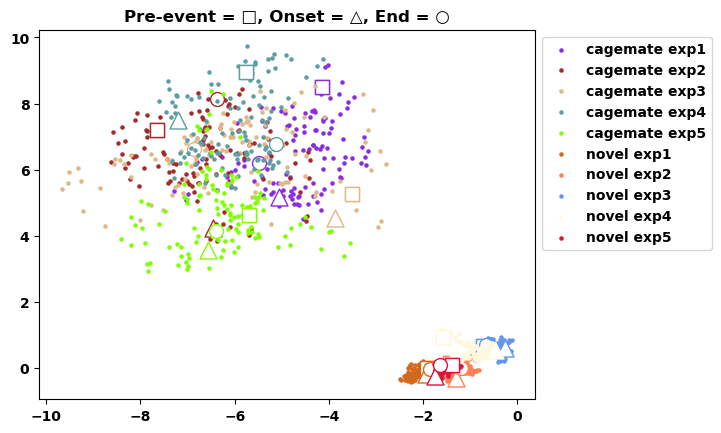

In [80]:
from importlib import reload
reload(pca_trajectories)
events = ['exp1', 'exp2', 'exp3', 'exp4', 'exp5']
#events = ['novel', 'not_novel']
event_length=4
pre_window = 2
post_window=0
min_neurons=5
plot= False
whole_collection.analyze(timebin = 50, smoothing_window=500, ignore_freq=0.5)
pca_result = pca_trajectories.coniditon_pca(whole_collection, condition_dict,events = events, event_length=event_length, pre_window=pre_window, min_neurons=min_neurons, plot=True)

In [81]:
print(pca_result)

PCA Result with:
Events: exp1, exp2, exp3, exp4, exp5
Timebins per event: 120.0
Total neurons: 261
Number of recordings: 18
Number of Pcs needed to explain 90% of variance 18


<class 'dict'>


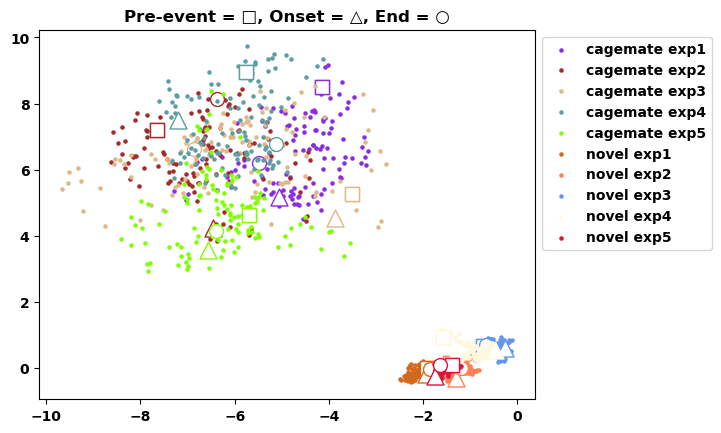

In [53]:
PCA_key = pca_result.labels
pca_matrix = pca_result.transformed_data
print(type(pca_matrix))
conv_factor = 1000 / whole_collection.timebin
event_lengths = int((event_length + pre_window + post_window) * conv_factor)
event_end = int((event_length + pre_window) * conv_factor)
pre_window = pre_window * conv_factor
post_window = post_window * conv_factor
colors_dict = plt.cm.colors.CSS4_COLORS
colors = list(colors_dict.values())
col_counter = 10
for condition in condition_dict.keys():
    for i in range(0, len(PCA_key), event_lengths):
        event_label = PCA_key[i]
        onset = i if pre_window == 0 else int(i + pre_window - 1)
        end = int(i + event_end - 1)
        post = int(i + event_lengths - 1)
        plt.scatter(
            pca_matrix[condition][i : i + event_lengths, 0],
            pca_matrix[condition][i : i + event_lengths, 1],
            label=f"{condition} {event_label}",
            s=5,
            c=colors[col_counter],
        )
        if pre_window != 0:
            plt.scatter(pca_matrix[condition][i, 0], pca_matrix[condition][i, 1], marker="s", s=100, c="w", edgecolors=colors[col_counter])
            plt.scatter(pca_matrix[condition][i, 0], pca_matrix[condition][i, 1], marker="s", s=100, c="w", edgecolors=colors[col_counter])
        plt.scatter(
            pca_matrix[condition][onset, 0], pca_matrix[condition][onset, 1], marker="^", s=150, c="w", edgecolors=colors[col_counter]
        )
        plt.scatter(pca_matrix[condition][end, 0], pca_matrix[condition][end, 1], marker="o", s=100, c="w", edgecolors=colors[col_counter])
        if post_window != 0:
            plt.scatter(
                pca_matrix[condition][post, 0], pca_matrix[condition][post, 1], marker="D", s=100, c="w", edgecolors=colors[col_counter]
            )
        col_counter += 1
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
post_win_text = ""
pre_win_text = ""
if post_window != 0:
    post_win_text = ", Post = ◇"
if pre_window != 0:
    pre_win_text = "Pre-event = □, "
title = pre_win_text + "Onset = △, End = ○" + post_win_text
plt.title(title)
plt.show()